<a href="https://colab.research.google.com/github/billptw/SIH19-RNN-Epidemiological-Prediction/blob/master/RNN_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My\ Drive/CE7454_Group_38/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/CE7454_Group_38


# **1. Problem Motivation**
*   It is not uncommon that searches of a particular disease tend to spike at the initial onset of an outbreak
*   Google has been the go-to search engine over the past decade. Hence, there is a question as to how effective trends of searches can be used to predict a disease outbreak
*   These trend searches data can be used to train advanced predictive model like deep learning methods
*   Ultimately, an accurate predictive model can be used to help countries like India with big land massess to do advance medical resource allocation
*   In this project, we aim to use RNN-based models to predict weekly trend searches of diseases. The model will train on historical search trend data
*   A model will be trained for each Indian state

# **2. Data Acquisition**
*   Collecting data via Pytrend's API for Google Search
*   We scrape search trend data on "**flu**" for each state in India between 2012 to 2019
*   For each state, a .csv file is generated with weekly search trends between 2012 to 2019
*   The order of the number of unique data points per state ranges from tenth to hundredth making it extremely small

# **3. Data Exploration**
*   Google only provides relative search values (between 0-100), hence more data preprocessing is required in subsequent sections
*   We go through the scraping year by year from 2012 to 2019. This means that the data is rescaled by Google within a year
*   Each data point represents the total searches of the week (i.e. weekly data)
*   Not every state have the same number of unique data points



In [0]:
import pandas as pd
from pytrends.request import TrendReq
from tqdm import tqdm_notebook as tqdm

look_back = 4
bsz = 64
epochs = 5000
n_hidden = 32
years = []
#list_of_states = ['IN-TN', 'IN-KL', 'IN-KA', 'IN-AP', 'IN-GA', 'IN-MH','IN-CT','IN-OR','IN-MP','IN-GJ','IN-RJ','IN-UP','IN-JH','IN-WB','IN-BR','IN-HR','IN-PB','IN-HP','IN-JK','IN-UT','IN-SK','IN-ML','IN-AS','IN-AR','IN-NL','IN-MZ','IN-TR','IN-MN','IN-AN','IN-DL','IN-CH','IN-DD','IN-PY','IN-TG','IN-DN'],'IN-ML','IN-AS','IN-AR','IN-NL','IN-MZ','IN-TR','IN-MN','IN-AN','IN-DL','IN-CH','IN-DD','IN-PY','IN-TG','IN-DN']
list_of_states = ['IN-BR','IN-HR','IN-PB','IN-HP','IN-JK','IN-UT','IN-SK','IN-ML','IN-AS','IN-AR','IN-NL','IN-MZ','IN-TR','IN-MN','IN-AN','IN-DL','IN-CH','IN-DD','IN-PY','IN-TG','IN-DN']
pytrends = TrendReq(hl='en-US', tz=360)
#pytrends = TrendReq(hl='en-US', tz=360, timeout=(10,25), proxies=['https://34.203.233.13:80',], retries=2, backoff_factor=0.1)
start = 12
end = 19
for i in tqdm(range(len(list_of_states))):
    date1 = '20' + str(start) + '-01-01'
    date2 = '20' + str(start) + '-12-31'
    kw_list = ["flu"]
    time_frame = date1 + ' ' + date2
    pytrends.build_payload(kw_list, cat=0, timeframe=time_frame, geo=list_of_states[i], gprop='')
    total_per_state = pytrends.interest_over_time()
    for j in range(start+1, end):
        date1 = '20' + str(j) + '-01-01'
        date2 = '20' + str(j) + '-12-31'
        kw_list = ["flu"]
        time_frame = date1 + ' ' + date2
        pytrends.build_payload(kw_list, cat=0, timeframe=time_frame, geo=list_of_states[i], gprop='')
        temp = pytrends.interest_over_time()
        total_per_state = pd.concat([total_per_state, temp], axis=0)
    total_per_state.to_csv(r'' + list_of_states[i] + str(start) + '_' + str(end-1) +'.csv')
    date1 = '20' + str(end-1) + '-12-09'
    date2 = '20' + str(end) + '-12-31'
    kw_list = ["flu"]
    time_frame = date1 + ' ' + date2
    pytrends.build_payload(kw_list, cat=0, timeframe=time_frame, geo=list_of_states[i], gprop='')
    temp = pytrends.interest_over_time()
    temp.to_csv(r'' + list_of_states[i] + str(end) +'.csv')

# **4. Preprocessing and Packing of Data**
*   As mentioned, data are scaled relative to the whole year. Hence, there is no way to recover absolute value of the searches
*   The most useful thing that can be done is to do a prediction relative to the past 5 weeks 
*   This can then give an idea of how bad the searches is going to be in the coming week
*   Hence, each data point is packed as an input (X) of 5 weeks and a label (Y) of the 6th week.
*   Since the focus is on the relative magnitude among the 6 weeks considered, we do a min-max scaling among the 6 weeks for the train data per data instance

 >$X_{scaled} = \frac{X - X_{min}}{X_{max}-X_{min}}$

 *where $X_{min}$, $X_{max}$ and $X_{scaled}$ are the minimum, maximum and scaled values of each of the data points within the each 6 weeks window frame* 


*   A training instance for each Indian state is generated by rolling a 6 weeks window forward by 1 week through the time-series data
*   The data is arbitarily split between a train and test set. We train on data from 2012 to 2018 and test on the data of 2019


# **5. Initialise and Training the Deep Learning Model**
*   The output is a prediction of the 6th week trend relative to an input of the past 5 weeks
*   We train a model for each state, hence if we have 30 states, then we would have 30 neural network models.
*   Note that we added a fully connected layer to combine all the previous prediction of the LSTM rather than just taking the last term
*   We train with mini-batches of batch size 64 for some predefined epoch. The maximum number of epoch was determined from visual inspection from the loss curve
*   We observed that on the average across all the Indian states, loss plateaus after around 300 epoch. Thus, we set the maximum epoch to be 500 just to be safe






In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# LSTM Model Definition
class Flu_LSTM(nn.Module):
    def __init__(self, in_size, n_hidden, look_back, n_layers=2):
        super(Flu_LSTM, self).__init__()
        self.out = 1
        self.in_size = in_size
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.look_back = look_back
        self.lstm = nn.LSTM(in_size, self.n_hidden, n_layers, batch_first=True, dropout=0.3)
        self.fc1 = nn.Linear(self.n_hidden*self.look_back, 1)

    def forward(self, x, h):
        # Forward propagate LSTM
        y, (h, c) = self.lstm(x, h)
        y = y.reshape(y.shape[0],-1)
        out = self.fc1(y)
        return out, (h, c)
    
    def init_hidden(self, bszh):
        return (torch.zeros(self.n_layers, bszh, self.n_hidden), torch.zeros(self.n_layers, bszh, self.n_hidden)) 

# RNN Model Definition
class Flu_RNN(nn.Module):
    def __init__(self, in_size, n_hidden, look_back, n_layers=2):
        super(Flu_RNN, self).__init__()
        self.out = 1
        self.in_size = in_size
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.look_back = look_back
        self.rnn = nn.RNN(in_size, self.n_hidden, n_layers, batch_first=True, dropout=0.3)
        self.fc1 = nn.Linear(self.n_hidden*self.look_back, 1)

    def forward(self, x, h):
        # Forward propagate
        y, h = self.rnn(x, h)
        y = y.reshape(y.shape[0],-1)
        out = self.fc1(y)
        return out, h
    
    def init_hidden(self, bszh):
        return torch.zeros(self.n_layers, bszh, self.n_hidden) 


# GRU Model Definition
class Flu_GRU(nn.Module):
    def __init__(self, in_size, n_hidden, look_back, n_layers=2):
        super(Flu_GRU, self).__init__()
        self.out = 1
        self.in_size = in_size
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.look_back = look_back
        self.gru = nn.GRU(in_size, self.n_hidden, n_layers, batch_first=True, dropout=0.3)
        self.fc1 = nn.Linear(self.n_hidden*self.look_back, 1)

    def forward(self, x, h):
        # Forward propagate
        y, h = self.gru(x, h)
        y = y.reshape(y.shape[0],-1)
        out = self.fc1(y)
        return out, h
    
    def init_hidden(self, bszh):
        return torch.zeros(self.n_layers, bszh, self.n_hidden) 


0 tensor(0.3453, grad_fn=<MeanBackward0>)
50 tensor(0.0918, grad_fn=<MeanBackward0>)
100 tensor(0.0509, grad_fn=<MeanBackward0>)
150 tensor(0.0714, grad_fn=<MeanBackward0>)
200 tensor(0.0703, grad_fn=<MeanBackward0>)
250 tensor(0.0683, grad_fn=<MeanBackward0>)
300 tensor(0.0591, grad_fn=<MeanBackward0>)
350 tensor(0.0761, grad_fn=<MeanBackward0>)
400 tensor(0.0674, grad_fn=<MeanBackward0>)
450 tensor(0.0733, grad_fn=<MeanBackward0>)


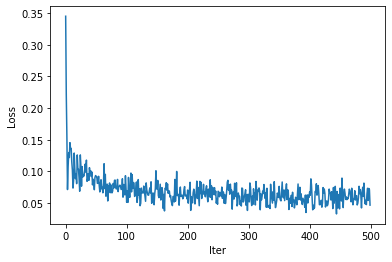

RuntimeError: ignored

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
import random

look_back = 5
bsz = 64
epochs = 500
n_hidden = 32
years = []
list_of_states = ['IN-TN', 'IN-KL', 'IN-KA', 'IN-AP', 'IN-GA', 'IN-MH','IN-CT','IN-OR','IN-MP','IN-GJ','IN-RJ','IN-UP','IN-JH','IN-WB','IN-BR','IN-HR','IN-PB','IN-HP','IN-JK','IN-UT','IN-SK','IN-ML','IN-AS','IN-AR','IN-NL','IN-MZ','IN-TR','IN-MN','IN-AN','IN-DL','IN-CH','IN-DD','IN-PY','IN-TG','IN-DN']

start = 12
end = 19
all_states_performance = {}
all_states_final = {}
err = 1e-8
key_word = 'flu'
def detach(states):
  if type(states) == tuple:
    return [state.detach() for state in states]
  else:
    return states.detach()

for j in range(len(list_of_states)):
    # Feature scaling and pack data
    sc = MinMaxScaler(feature_range = (0, 1))
    X_train = []
    Y_train = []
    loss_history = []
    
    # Pack data for LSTM
    dataset_train = pd.read_csv(list_of_states[j] + str(start) + '_' + str(end-1) +'.csv')[key_word]
    
    training_set = dataset_train.values.reshape(-1,1)
    for i in range(look_back, len(training_set)-1):
        train_scaled = sc.fit_transform(training_set[i-look_back:i+1, 0].reshape(-1,1))
        temp = train_scaled[:-1, 0].reshape(look_back , 1)
        temp2 = train_scaled[-1, 0].reshape(1)
        X_train.append(temp)
        Y_train.append(temp2)
        
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1]))
    z = torch.Tensor(X_train)
    targets = torch.Tensor(Y_train)
    
    # Define model 
    #model = Flu_LSTM(1, n_hidden, look_back)
    #model = Flu_GRU(1, n_hidden, look_back)
    model = Flu_RNN(1, n_hidden, look_back)

    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.MSELoss()

    # Start training
    for epoch in range(epochs):
        # Set initial hidden and cell states
        hidden = model.init_hidden(bsz)
    
        # Get mini-batch inputs and targets
        indx = np.random.randint(X_train.shape[0], size=bsz)
        inputs = z[indx,:,:]
        target = targets[indx,:]
    
        # Forward pass
        hidden = detach(hidden)
        y, hidden = model.forward(inputs, hidden)
        loss = criterion(target, y)
    
        # Backward and optimize
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history.append(loss)
        if epoch%50==0: 
            print (epoch, loss)

    plt.plot(loss_history)
    plt.xlabel('Iter')
    plt.ylabel('Loss')
    #plt.savefig(r'' + 'loss_' + list_of_states[j] + str(start) + '_' + str(end-1) + '.jpg')
    plt.show()
    
    #start test loop
    X_test = []
    Y_test = []
    Y_random = []
    # dataset_test = pd.read_csv(r'./data_flu/'+ list_of_states[j] + str(end) +'.csv')[key_word]
    dataset_test = pd.read_csv(list_of_states[j] + str(end) +'.csv')[key_word]

    test_set = dataset_test.values.reshape(-1,1)
    for i in range(look_back, len(test_set)):
        test_scaled = sc.fit_transform(test_set[i-look_back:i, 0].reshape(-1,1))
        temp = test_scaled[:, 0].reshape(look_back, 1)
        test_scaled1 = sc.fit_transform(test_set[i-look_back:i+1, 0].reshape(-1,1))
        temp2 = test_scaled1[:, 0].reshape(-1)
        temp3 = np.array(random.random()).reshape(1)
        X_test.append(temp)
        Y_test.append(temp2)
        Y_random.append(temp3)
    
    model.eval()   
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    real = np.array(Y_test)
    Y_random = np.array(Y_random)
    X_test = torch.Tensor(X_test)
    hidden = model.init_hidden(int(X_test.shape[0]))
    hidden = detach(hidden)
    y, _ = model.forward(X_test, hidden)
    y = np.array(y.detach())
    predicted = np.concatenate((X_test.reshape(X_test.shape[0],X_test.shape[1]),y),axis=1)
    rand = np.concatenate((X_test.reshape(X_test.shape[0],X_test.shape[1]),Y_random),axis=1)
    
    total_r_s = []
    total_r_s_rank_predicted = []
    total_r_s_rank_real = []
    
    total_r_s_1 = []
    total_r_s_1_pvalue = []
    
    total_r_s_1_r = []
    total_r_s_1_pvalue_r = []
    
    total_c_c = []
    total_c_c_r = []
    
    for i in range(real.shape[0]):
        predicted_rank = stats.rankdata(predicted[i], method='average')
        real_rank = stats.rankdata(real[i], method='average')
        total_r_s_rank_predicted.append(predicted_rank)
        total_r_s_rank_real.append(real_rank)
        n = real.shape[1]
        diffs = real_rank - predicted_rank
        r_s = 1 - 6*sum(diffs*diffs)/(n*(n**2 - 1))
        r_s_1, p_value = stats.spearmanr(real[i]+err, predicted[i]+2*err)
        r_s_1_r, p_value_r = stats.spearmanr(real[i]+err, rand[i]+2*err)
        c_c = np.corrcoef(real[i]+err, predicted[i]+2*err)[0,1]
        c_c_r = np.corrcoef(real[i]+err, rand[i]+2*err)[0,1]
        total_r_s.append(r_s)
        total_r_s_1.append(r_s_1)
        total_r_s_1_pvalue.append(p_value)
        total_r_s_1_r.append(r_s_1_r)
        total_r_s_1_pvalue_r.append(p_value_r)
        total_c_c.append(c_c)
        total_c_c_r.append(c_c_r)
    
    avg_r_s = np.array(total_r_s).mean()
    avg_r_s_1 = np.array(total_r_s_1).mean()
    avg_r_s_1_pvalue = np.array(total_r_s_1_pvalue).mean()
    avg_r_s_1_r = np.array(total_r_s_1_r).mean()
    avg_r_s_1_pvalue_r = np.array(total_r_s_1_pvalue_r).mean()
    avg_c_c = np.array(total_c_c).mean()
    avg_c_c_r = np.array(total_c_c_r).mean()
    print('The average Spearman Rank Coefficient is:', avg_r_s)
    print('The average Spearman Rank Coefficient_1 is:', avg_r_s_1, 'with p_value of:', avg_r_s_1_pvalue)
    print('The average Correlation Coefficient is:', avg_c_c)
    print('The average Spearman Rank Coefficient (random) is:', avg_r_s)
    print('The average Spearman Rank Coefficient_1 (random) is:', avg_r_s_1_r, 'with p_value of:', avg_r_s_1_pvalue_r)
    print('The average Correlation Coefficient (random) is:', avg_c_c_r)
    #pd.DataFrame(predicted).to_csv(r'' + list_of_states[j] + str(end) + 'predicted'+'.csv')
    all_states_performance[list_of_states[j]] = [avg_r_s_1, avg_r_s_1_pvalue, avg_c_c, avg_r_s_1_r, avg_r_s_1_pvalue_r, avg_c_c_r]
    
    final_x_scaled = sc.fit_transform(test_set[len(test_set)-look_back:len(test_set), 0].reshape(-1,1))
    temp = final_x_scaled[:, 0].reshape(look_back, 1)
    temp1 = torch.Tensor(temp).reshape(1,-1,1)
    hidden = model.init_hidden(int(temp1.shape[0]))
    hidden = detach(hidden)
    final_y, _ = model.forward(temp1, hidden)
    final_y = np.array(final_y.detach())
    final = np.concatenate((np.transpose(temp), final_y),axis=1)
    all_states_final[list_of_states[j]] = final.reshape(-1)*100

all_states_performance = pd.DataFrame.from_dict(all_states_performance, orient='index', columns=['SRCorr', 'SR_pvalue', 'Corr','SRCorr (r)', 'SR_pvalue(r)', 'Corr(r)'])
all_states_performance.to_csv(r'' + 'all_' + str(end) + 'predicted_performances'+'.csv')

all_states_final = pd.DataFrame.from_dict(all_states_final, orient='index')
all_states_final.to_csv(r'' + 'all_' + str(end) + 'predicted_final'+'.csv')


# **6. Testing and Analysing of the Results**
*   The prediction is tested on the test set that the model has not seen before for the year 2019
*   As we are interested in measuring how well the predicted 6th week fits the trend relaive to the past 5 weeks, we use the Pearson correlation coefficient instead of MSE

 >$pearson = \frac{{}\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}
{\sqrt{\sum_{i=1}^{n} (x_i - \overline{x})^2(y_i - \overline{y})^2}}$

 *where $x_i$, $y_i$ are the 2 sets of data and n is the number of data points*

*   The correlation coefficient is measured between the predicted trend and the true trend for the 6 weeks period and averaged out across the test set for each Indian state
*   MSE may not serve the best purpose here since we care more about relative trends within the 6 weeks window and also because of the lack of absolute values to compare against
*   In addition, we added the Spearman rank coefficients which is scale agnostic for measuring the correlation more accurately:

 >$spearman = 1- {\frac {6 \sum d_i^2}{n(n^2 - 1)}}$

  *where d is the pairwise rank differences between the two set of data and n is the number of data points*

*   The predicted values here are nothing but relatives to the past 5 weeks
*   To avoid look ahead bias, the min-max scaling here is done only on the 5 weeks of inputs (in contrast to how it was done in the train set)
*   To further show that our model actually picks up interesting trends, we compare the performance with an untrained random neural network model
*   If our models perform better than the untrained random neural network, we can conclude reasonably that the training process was effective and that the network picked up some statistical relationship
*   We showed that all 3 of our models are better than an untrained random model(r) in terms of the Pearson and Spearman rank coefficients


|Model| SRCorr|SR_pvalue|Corr|SRCorr(r)|SR_pvalue(r)|Corr(r)| 
|------| ------------- |---------------| ------|------------- |---------------| ------|
|LSTM| 0.842922|0.070021|0.850378|0.805962 |0.094018 |0.803782 |
|GRU| 0.841829|0.069762|0.851068|0.806070|0.094747|0.804042 |
|RNN| 0.842005|0.071110|0.850333|0.800184|0.099372|0.795190 |

In [0]:
import pandas as pd
all_states_performance_filtered = pd.read_csv('all_19predicted_performances.csv').dropna()
all_states_performance_filtered_avg = all_states_performance_filtered.describe()
print(all_states_performance_filtered_avg)